In [ ]:
import numpy as np
from utils import time_plot, get_figure, fit_sinusoids, plot_fft
from matplotlib import pyplot as plt

from data.ex_data import get_sea_surface_temp

(0.0, 500.0)

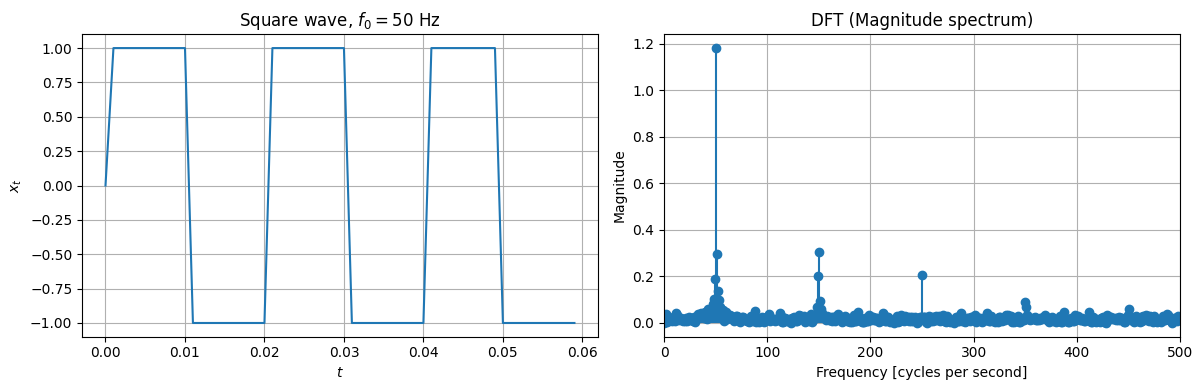

In [2]:
n = 1024
fs = 1000.0          
sr = 1.0 / fs
t = np.arange(n) * sr
f0 = 50.0            

square = np.sign(np.sin(2 * np.pi * f0 * t))

fig, axs = get_figure(nrows=1, ncols=2, figsize=(12, 4))

# only first 3 periods
period = int(fs / f0)
time_plot(
    t[:3*period], square[:3*period],
    ax=axs[0],
    title=r"Square wave, $f_0 = 50$ Hz"
)

plot_fft(
    axs[1],
    square,
    sample_spacing=sr,
    sample_spacing_name="second"
)
axs[1].set_xlim(0, fs/2)  # only positive frequencies


### Single Impulse Middle

Text(0.5, 1.0, 'DFT magnitude – flat spectrum')

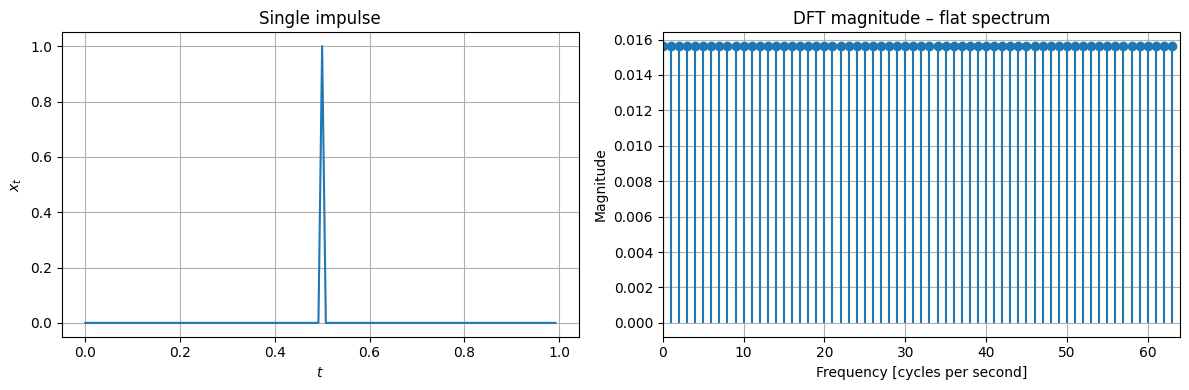

In [3]:
# Single impulse in the middle
n = 128
fs = 128.0
sr = 1.0 / fs
t = np.arange(n) * sr

impulse = np.zeros(n)
impulse[n//2] = 1.0

fig, axs = get_figure(nrows=1, ncols=2, figsize=(12, 4))

time_plot(
    t, impulse,
    ax=axs[0],
    title="Single impulse"
)

plot_fft(
    axs[1],
    impulse,
    sample_spacing=sr,
    sample_spacing_name="second"
)
axs[1].set_xlim(0, fs/2)
axs[1].set_title("DFT magnitude – flat spectrum")

Text(0.5, 1.0, 'DFT magnitude – comb spectrum')

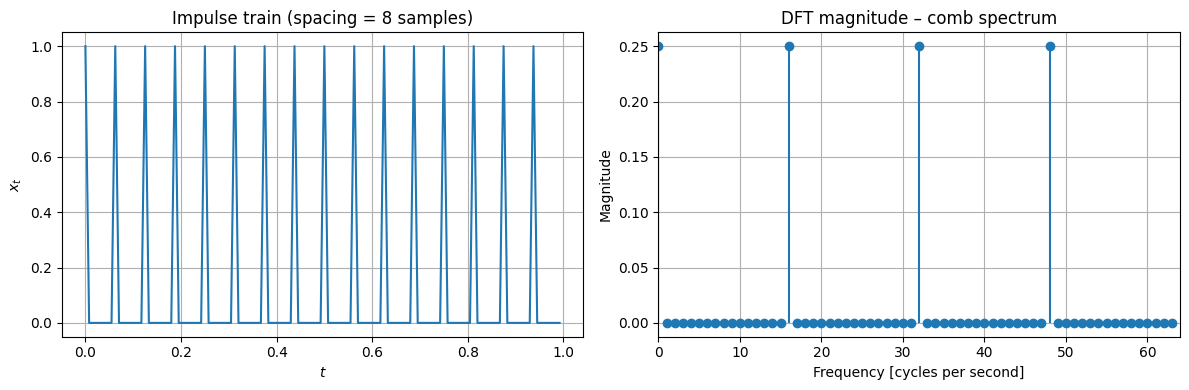

In [4]:
# Impulse train: every 8 samples
n = 128
fs = 128.0
sr = 1.0 / fs
t = np.arange(n) * sr

impulse_train = np.zeros(n)
impulse_train[::8] = 1.0

fig, axs = get_figure(nrows=1, ncols=2, figsize=(12, 4))

time_plot(
    t, impulse_train,
    ax=axs[0],
    title="Impulse train (spacing = 8 samples)"
)

plot_fft(
    axs[1],
    impulse_train,
    sample_spacing=sr,
    sample_spacing_name="second"
)
axs[1].set_xlim(0, fs/2)
axs[1].set_title("DFT magnitude – comb spectrum")

### Time-shift DFT

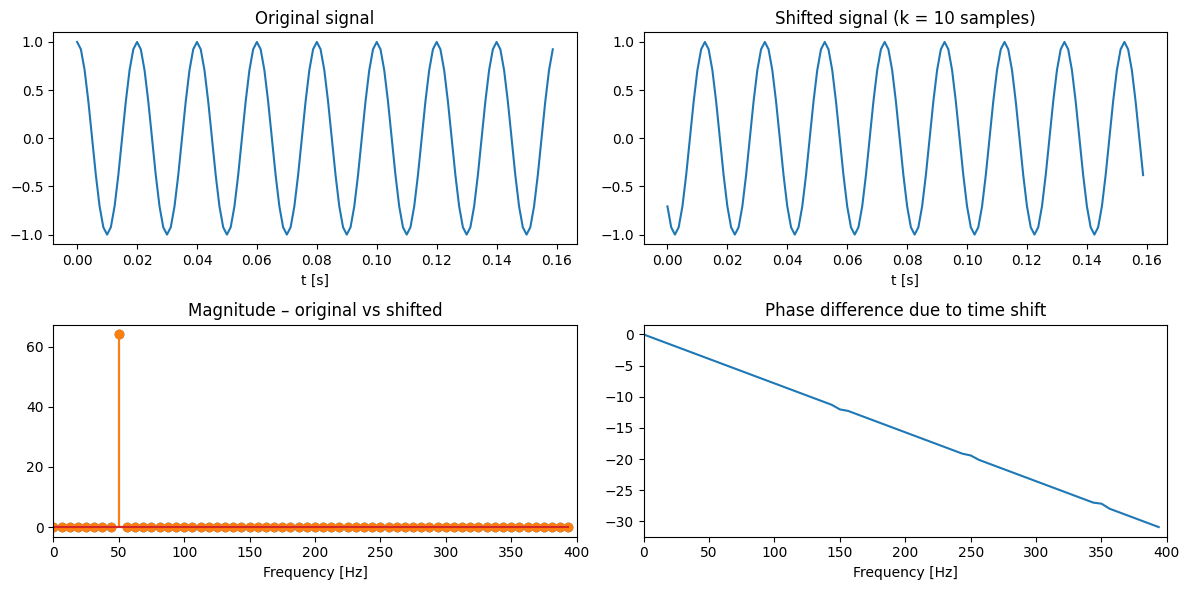

In [5]:
n = 128
fs = 800.0
sr = 1.0 / fs
t = np.arange(n) * sr
f0 = 50.0

x = np.cos(2 * np.pi * f0 * t)

k = 10
x_shift = np.roll(x, k)

X = np.fft.fft(x)
X_shift = np.fft.fft(x_shift)
freqs = np.fft.fftfreq(n, d=sr)

mask = freqs >= 0
freqs_pos = freqs[mask]
X_pos = X[mask]
X_shift_pos = X_shift[mask]

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

axs[0, 0].plot(t, x)
axs[0, 0].set_title("Original signal")
axs[0, 0].set_xlabel("t [s]")

axs[0, 1].plot(t, x_shift)
axs[0, 1].set_title(f"Shifted signal (k = {k} samples)")
axs[0, 1].set_xlabel("t [s]")

# Magnitude
axs[1, 0].stem(freqs_pos, np.abs(X_pos))
axs[1, 0].stem(freqs_pos, np.abs(X_shift_pos), linefmt='C1-', markerfmt='C1o')
axs[1, 0].set_xlim(0, fs/2)
axs[1, 0].set_title("Magnitude – original vs shifted")
axs[1, 0].set_xlabel("Frequency [Hz]")

phase_diff = np.angle(X_shift_pos) - np.angle(X_pos)
phase_diff = np.unwrap(phase_diff)

axs[1, 1].plot(freqs_pos, phase_diff)
axs[1, 1].set_xlim(0, fs/2)
axs[1, 1].set_title("Phase difference due to time shift")
axs[1, 1].set_xlabel("Frequency [Hz]")

plt.tight_layout()

### Sampling-rate effects & aliasing

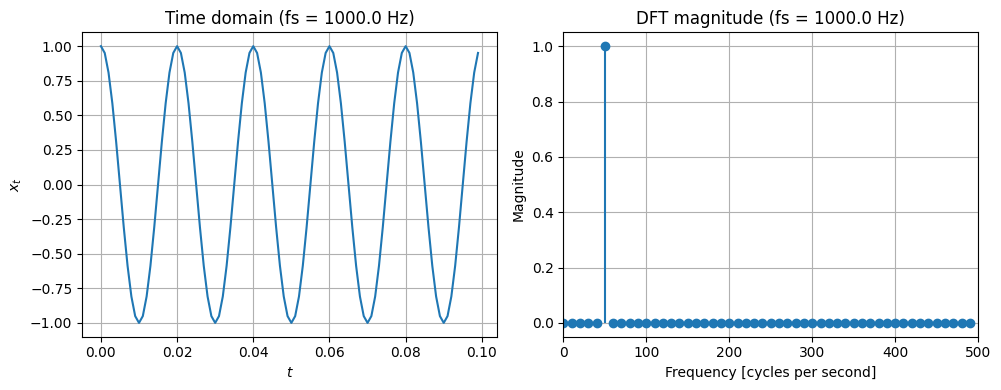

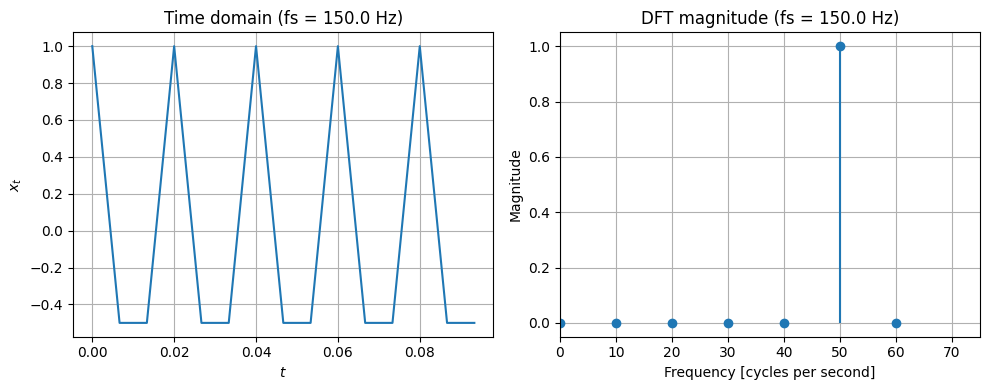

In [ ]:
f0 = 50.0          # true signal frequency

def sample_and_plot(fs, n_cycles=5):
    sr = 1.0 / fs
    T = n_cycles / f0
    n = int(T * fs)
    t = np.arange(n) * sr
    x = np.cos(2 * np.pi * f0 * t)

    fig, axs = get_figure(nrows=1, ncols=2, figsize=(10, 4))
    time_plot(
        t, x,
        ax=axs[0],
        title=f"Time domain (fs = {fs} Hz)"
    )
    plot_fft(
        axs[1],
        x,
        sample_spacing=sr,
        sample_spacing_name="second"
    )
    axs[1].set_xlim(0, fs/2)
    axs[1].set_title(f"DFT magnitude (fs = {fs} Hz)")

sample_and_plot(fs=1000.0)

sample_and_plot(fs=150.0)

Text(0.5, 1.0, 'DFT magnitude – shows aliased frequency')

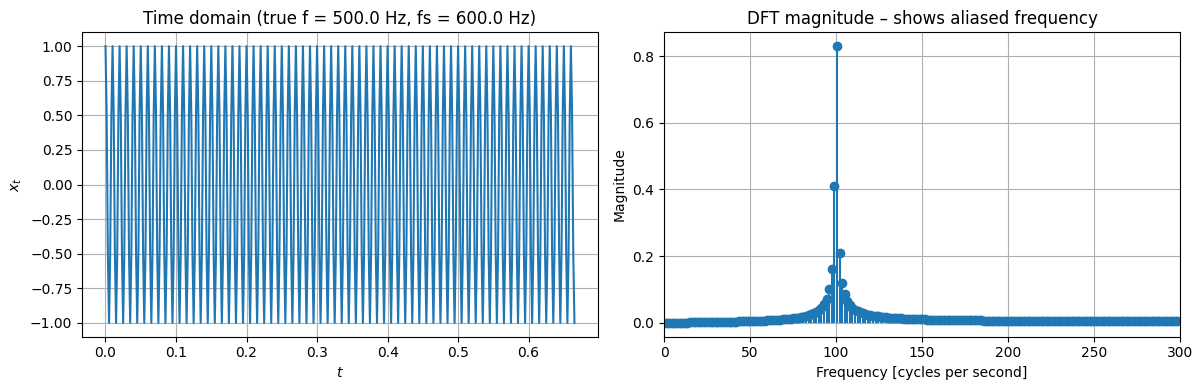

In [ ]:
f0 = 500.0        
fs = 600.0          
sr = 1.0 / fs

n = 400
t = np.arange(n) * sr
x = np.cos(2 * np.pi * f0 * t)

fig, axs = get_figure(nrows=1, ncols=2, figsize=(12, 4))

time_plot(
    t, x,
    ax=axs[0],
    title=f"Time domain (true f = {f0} Hz, fs = {fs} Hz)"
)

plot_fft(
    axs[1],
    x,
    sample_spacing=sr,
    sample_spacing_name="second"
)
axs[1].set_xlim(0, fs/2)
axs[1].set_title("DFT magnitude – shows aliased frequency")

### Reconstruct with inverse DFT

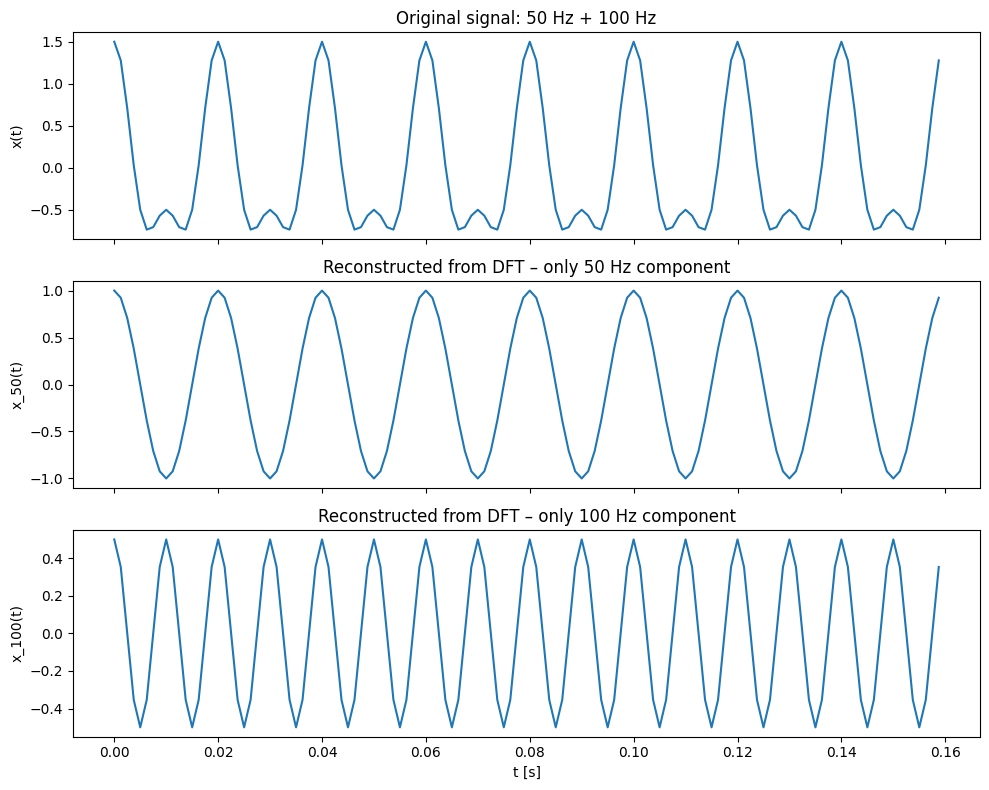

In [ ]:
n = 128
fs = 800.0
sr = 1.0 / fs
t = np.arange(n) * sr

signal1 = np.cos(2 * np.pi * 50 * t)
signal2 = 0.5 * np.cos(2 * np.pi * 100 * t)
x = signal1 + signal2

X = np.fft.fft(x)
freqs = np.fft.fftfreq(n, d=sr)

def keep_frequency_component(X, freqs, target_f, tol=1e-6):
    X_filtered = np.zeros_like(X, dtype=complex)
    mask_pos = np.isclose(freqs,  target_f, atol=tol)
    mask_neg = np.isclose(freqs, -target_f, atol=tol)
    X_filtered[mask_pos | mask_neg] = X[mask_pos | mask_neg]
    return X_filtered

X_50 = keep_frequency_component(X, freqs, 50.0)
x_50 = np.fft.ifft(X_50).real

X_100 = keep_frequency_component(X, freqs, 100.0)
x_100 = np.fft.ifft(X_100).real

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(t, x)
axs[0].set_title("Original signal: 50 Hz + 100 Hz")
axs[0].set_ylabel("x(t)")

axs[1].plot(t, x_50)
axs[1].set_title("Reconstructed from DFT – only 50 Hz component")
axs[1].set_ylabel("x_50(t)")

axs[2].plot(t, x_100)
axs[2].set_title("Reconstructed from DFT – only 100 Hz component")
axs[2].set_ylabel("x_100(t)")
axs[2].set_xlabel("t [s]")

plt.tight_layout()